In [1]:
# To-do's: remove unnecessary words
# redo for mentions rather than user
# export analysis df to csv
# visualize in tableau
# Figure out how to get more than 100 tweets

In [82]:
# Library Imports
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import config
import sys
import jsonpickle
import os
from unidecode import unidecode

plt.style.use('fivethirtyeight')

In [2]:
# Set variables for API keys and tokens
ak = config.apiKey
ask = config.apiSecretKey

## Additional tokens if needed ##
    # at = config.accessToken
    # ats = config.accessTokenSecret
## --------------------------- ##

# Create authentication object
authenticate = tweepy.AppAuthHandler(ak, ask)
authenticate.secure = True

# Make the API call wait when it hits the
# rate limit then continue upon expiry of the window 
api = tweepy.API(authenticate, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# Set condition for failed authentication
if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)

In [49]:
ceos = {'@elonmusk':'MuskTweets.txt','@JeffBezos':'BezosTweets.txt',
        '@BillGates':'GatesTweets.txt'}

# source: https://bit.ly/2WSO8El

searchQuery = '@elonmusk'
retweet_filter = '-filter:retweets'
q = searchQuery + retweet_filter
tweetsPerQry = 100
fName = 'MuskTweets.txt'
sinceId = None

max_id = -1
maxTweets = 300

tweetCount = 0
print(f"Downloading max {maxTweets} tweets")
with open(fName, 'w') as f:
    while tweetCount < maxTweets:
        try:
            if (max_id <= 0):
                if (not sinceId):
                    new_tweets = api.search(q = searchQuery + retweet_filter, count=tweetsPerQry)
                else:
                    new_tweets = api.search(q = searchQuery + retweet_filter, count=tweetsPerQry,
                                            since_id=sinceId)
            else:
                if (not sinceId):
                    new_tweets = api.search(q = searchQuery + retweet_filter, count=tweetsPerQry,
                                            max_id=str(max_id - 1))
                else:
                    new_tweets = api.search(q = searchQuery + retweet_filter, count=tweetsPerQry,
                                            max_id=str(max_id - 1),
                                            since_id=sinceId)
            if not new_tweets:
                print("No more tweets found")
                break
            for tweet in new_tweets:
                f.write(jsonpickle.encode(tweet._json['text'], unpicklable=False) + '\n')
            tweetCount += len(new_tweets)
            max_id = new_tweets[-1].id
        except tweepy.TweepError as e:
            # Just exit if any error
            print("some error : " + str(e))
            break

print (f"Downloaded {tweetCount} tweets, Saved to {fName}")

Downloaded 5096 tweets, Saved to MuskTweets.txt


In [69]:
# # Extract 100 tweets from user
# # posts = api.user_timeline(screen_name = "BillGates", count = 1000, lang = "en", tweet_mode = "extended")

# tweets = []
# # Print last 5 tweets from user
# print("5 most recent tweets: \n")

# for status in tweepy.Cursor(api.user_timeline, screen_name='@elonmusk', tweet_mode="extended").items():
#     tweets.append(status.full_text)

# i = 1

# for tweet in tweets[:5]:

#     print(str(i) + '. ' + tweet + '\n')
    
#     i += 1

In [126]:
# Create dataframe containing tweets
df = pd.read_fwf('MuskTweets.txt', sep = '\n', header = None)

df.columns = ['Tweets']

df

,Tweets
0,"""@elonmusk The crazier part is that people exi..."
1,"""@elonmusk well, looks like I'll never support..."
2,"""@realDonaldTrump @elonmusk @Tesla Ya with une..."
3,"""@elonmusk I\u2019ll build another."""
4,"""@elonmusk Yes it does"""
...,...
5091,"""@hotepdoll @charliereif @elonmusk Ok so what ..."
5092,"""@RichardRyszardR @crackitycracken @throwaway7..."
5093,"""@elonmusk insta is better than twitter \ud83d..."
5094,"""@timthetatman @elonmusk Dude neuralink sounds..."


In [128]:
# Clean tweets
def cleanTxt(text):
    
    text = re.sub(r'@[A-Za-z0-9]+','',text) # Remove @mentions
    text = re.sub(r'#','',text) # Remove '#' symbols
    text = re.sub(r'RT[\s]+','',text) # Remove retweets
    text = re.sub(r'https?:\/\/\S+','',text) # Remove hyperlink
    text = re.sub(r':','',text) # Remove colons
    text = re.sub(r'\\u[A-Za-z0-9]+','',text) # Remove unicode
    return text

df['Tweets'] = df['Tweets'].apply(cleanTxt)

df

,Tweets
0,""" The crazier part is that people exist that g..."
1,""" well, looks like I'll never support your com..."
2,""" Ya with unemployment and job loss, who can..."
3,""" I build another."""
4,""" Yes it does"""
...,...
5091,""" Ok so what if me and my community decide t..."
5092,""" Hahaha this is"
5093,""" insta is better than twitter """
5094,""" Dude neuralink sounds wild too"""


In [129]:
# Create a function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Create two new columns
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

df

,Tweets,Subjectivity,Polarity
0,""" The crazier part is that people exist that g...",0.0000,0.0000
1,""" well, looks like I'll never support your com...",0.4375,0.1875
2,""" Ya with unemployment and job loss, who can...",0.0000,0.0000
3,""" I build another.""",0.0000,0.0000
4,""" Yes it does""",0.0000,0.0000
...,...,...,...
5091,""" Ok so what if me and my community decide t...",0.6000,0.6500
5092,""" Hahaha this is",0.4000,0.2000
5093,""" insta is better than twitter """,0.5000,0.5000
5094,""" Dude neuralink sounds wild too""",0.4000,0.1000


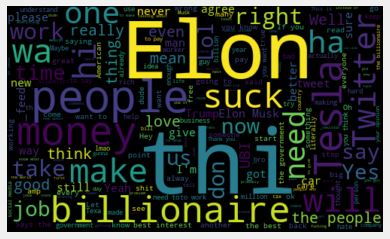

In [130]:
# Plot Word Cloud
allWords = ' '.join([twts for twts in df['Tweets']])
wordCloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()


In [131]:
# Compute negative, neutral and positive analysis

def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
df['Analysis'] = df['Polarity'].apply(getAnalysis)

df

,Tweets,Subjectivity,Polarity,Analysis
0,""" The crazier part is that people exist that g...",0.0000,0.0000,Neutral
1,""" well, looks like I'll never support your com...",0.4375,0.1875,Positive
2,""" Ya with unemployment and job loss, who can...",0.0000,0.0000,Neutral
3,""" I build another.""",0.0000,0.0000,Neutral
4,""" Yes it does""",0.0000,0.0000,Neutral
...,...,...,...,...
5091,""" Ok so what if me and my community decide t...",0.6000,0.6500,Positive
5092,""" Hahaha this is",0.4000,0.2000,Positive
5093,""" insta is better than twitter """,0.5000,0.5000,Positive
5094,""" Dude neuralink sounds wild too""",0.4000,0.1000,Positive


In [132]:
# Print positive tweets

j = 1

sortedDF = df.sort_values(by=['Polarity'], ascending=False)

for i in range(0, sortedDF.shape[0]):
    
    if (sortedDF['Analysis'][i] == 'Negative'):
    
        print(str(j) + '. ' + sortedDF['Tweets'][i] + '\n')
    
        j+=1

1. " How come Tesla cars are so damn ugly?"

2. " Unfortunately that is what makes the world economy go around. It takes 10 bribes for  to even laun 

3. " Shut up  what do you know about poor people????"

4. " You should sit down on this one."

5. "  _Hermes   Libs are the new Bolsheviks they just wanna destroy th 

6. "   _georgio    I find it odd you call t 

7. "  SOCIETY NOT READY FOR ELON ....\n\nUnfortunately "

8. "  Censorship = democracy?  \nYou on the wrong side of this war."

9. "    95% survival means 5% death rate. True or false?"

10. "    Desperate*"

11. "  sucks"

12. "   Is it hard playing a victim all the time. So now covid is spread because of white 

13. " Why dis it took You so long?"

14. " Wrong."

15. "    Half as hard, a billion times as smart."

16. ". is another example of unearned wealth masking mediocrity. 

17. " _BernardSandr   Which is very similar to what happens here in RO and to other storie 

18. " ...you hard!"

19. " Honestly not being sarcastic 

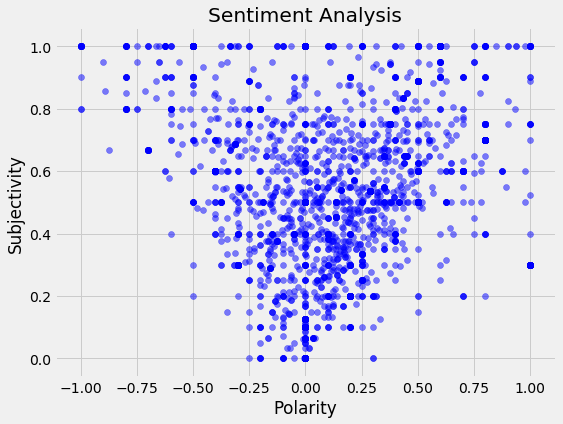

In [138]:
# Plot polarity and subjectivity

plt.figure(figsize = (8,6))

for i in range(0, df.shape[0]):
    plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color = 'Blue', alpha = 0.5)
    
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [134]:
# Get percentage of positive tweets
ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['Tweets']

round((ptweets.shape[0] / df.shape[0]*100), 1)

30.5

In [135]:
# Get percentage of negative tweets
ntweets = df[df.Analysis == 'Negative']
ntweets = ntweets['Tweets']

round((ntweets.shape[0] / df.shape[0]*100), 1)

15.1

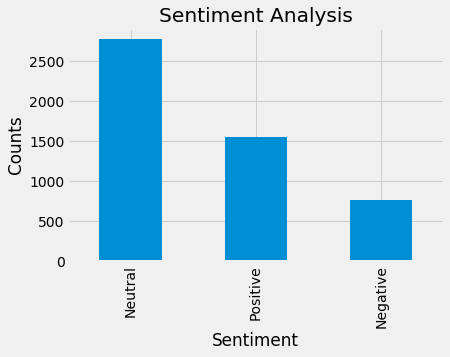

In [136]:
# Show value counts

plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')

df['Analysis'].value_counts().plot(kind='bar')
plt.show()